In [1]:


class MyParameters():
    def __init__(self, hog_color_space = 'YCrCb', orient = 17, pix_per_cell = 8, cell_per_block = 2, hog_channel = 0,
                spatial_color_space='RGB', spatial_size=(32, 32), spatial_color_channel = 0,
                nbins=32, bins_range=(0, 256),
                spatial_feat=True, hist_feat=False, hog_feat=True):
        self.hog_color_space = hog_color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_color_space = spatial_color_space
        self.spatial_size = spatial_size
        self.spatial_color_channel = 0
        self.nbins=nbins,
        self.bins_range=bins_range,
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        

parameters = MyParameters(
    hog_color_space = 'YCrCb',
    orient=17,
    pix_per_cell=8, 
    cell_per_block=2, 
    hog_channel=0,
    spatial_size=(32, 32),
    spatial_color_space='RGB', 
    spatial_color_channel=0,
    nbins=32, 
    bins_range=(0, 256),
    spatial_feat=True, 
    hist_feat=False, 
    hog_feat=True
)        
    

## Helper functions

In [5]:
# Helper functions
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
from skimage.feature import hog

from ipywidgets import FloatProgress
from IPython.display import display


# Define a function to compute binned color features  
def bin_spatial(img, parameters):
    feature_image = convert_color_space(img, parameters.spatial_color_space)   
    
    if parameters.spatial_color_channel == 'ALL':
        image = feature_image
    else:
        image = feature_image[:,:,parameters.spatial_color_channel]
        
    features = cv2.resize(image, parameters.spatial_size).ravel() 
    # Return the feature vector
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, parameters,
                        vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations=parameters.orient, 
                                  pixels_per_cell=(parameters.pix_per_cell, parameters.pix_per_cell),
                                  cells_per_block=(parameters.cell_per_block, parameters.cell_per_block), 
                                  transform_sqrt=True, 
                                  block_norm = 'L1',
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=parameters.orient, 
                       pixels_per_cell=(parameters.pix_per_cell, parameters.pix_per_cell),
                       cells_per_block=(parameters.cell_per_block, parameters.cell_per_block), 
                       transform_sqrt=True, 
                       block_norm = 'L1',
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute color histogram features 
def color_hist(img, parameters):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=parameters.nbins, range=parameters.bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=parameters.nbins, range=parameters.bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=parameters.nbins, range=parameters.bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def read_normalized(file_name):
    image = mpimg.imread(file_name)
    if file_name.endswith('png'):
        image = np.uint8(image * 255)
    return image
    

def convert_color_space(image,  color_space='RGB'):
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)      
    
    max_value = np.max(feature_image)
    
    return feature_image

def extract_features_single(image, parameters):
    
    file_features = []
   
    if parameters.spatial_feat == True:
        spatial_features = bin_spatial(image, parameters)
        file_features.append(spatial_features)
    
    if parameters.hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(image, parameters)
        file_features.append(hist_features)

    if parameters.hog_feat == True:
        hog_image = convert_color_space(image, parameters.hog_color_space)
        # Call get_hog_features() with vis=False, feature_vec=True
        if parameters.hog_channel == 'ALL':
            hog_features = []
            for channel in range(hog_image.shape[2]):
                hog_features.append(get_hog_features(hog_image[:,:,channel], 
                                    parameters, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_image[:,:,parameters.hog_channel], 
                                            parameters, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        #print("Hog features:", len(hog_features))
        file_features.append(hog_features)
        
    return np.concatenate(file_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, parameters):
    
    # Create a list to append feature vectors to
    features = []
    
    fprog = FloatProgress(min=0, max=len(imgs)-1)
    display(fprog)
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = read_normalized(file)
        
        image_features = extract_features_single(image, parameters)
        
        features.append(image_features)
        fprog.value += 1
        
    # Return list of feature vectors
    return features

## Find training images

In [6]:
import glob

car_fnames = glob.glob('./data/cars/*.png')
noncar_fnames = glob.glob('./data/non-cars/*.png')

print("Car images: ", len(car_fnames))
print("Non-car images:", len(noncar_fnames))



Car images:  17584
Non-car images: 17936


## Extract features

In [7]:
sample_size = 5000

car_features = extract_features(np.random.choice(car_fnames,sample_size), parameters)
print(len(car_features))


noncar_features = extract_features(np.random.choice(noncar_fnames,sample_size), parameters)
print(len(noncar_features))


C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


5000
5000


## Train classifier

In [8]:
import time
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib

classifier_fname = './cache/classifier.joblib.pkl'
scaler_fname = './cache/scaler.joblib.pkl'

# Normalize data
stack = np.vstack((car_features, noncar_features))
X = stack.astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
_ = joblib.dump(X_scaler, scaler_fname, compress=9) 


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))




# Uncomment following lines to train the classifier 
# Excution time ~20 minutes


#t=time.time()
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.3,1,3,10]}
#svr = svm.SVC()
#clf = GridSearchCV(svr, parameters)
#clf.fit(X_train, y_train)
#t2 = time.time()
#print(round(t2-t, 2), 'Seconds to find best parameters')
#_ = joblib.dump(clf, classifier_fname, compress=9) 


C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Feature vector length: 4356


## Test the classifier

In [9]:
clf = joblib.load(classifier_fname)

best_params = clf.best_params_
print("Classifier parameters:", best_params)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Classifier parameters: {'kernel': 'rbf', 'C': 3}
Test Accuracy of SVC =  0.99


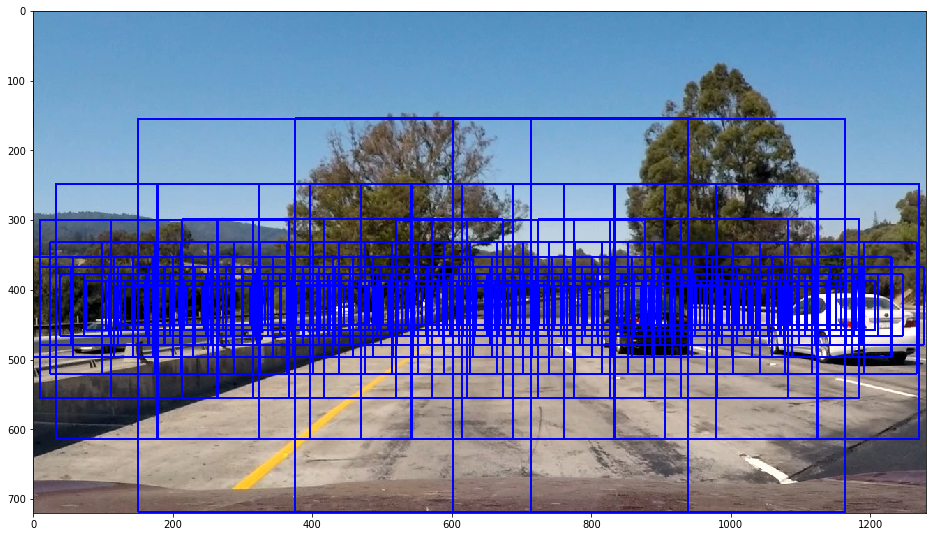

Windows count: 199


In [16]:
# Calculate windows positions

distance_step = 4
x_step = 1
x_near = 8
x_far = x_near + 15
window_size = 2.5 # car size

image_height = 720
image_width = 1280
lane_length = 50 # Lane length in meters
h0 = 0 # Cut bootm 20 pixels


# Perspective transformation points (taken from my previous project)
src = np.float32([[207,719],[597,450],[686,450],[1107,719]])
dst = np.float32([[300,719],[300,0],[979,0],[979,719]])

# Transformation matrix
M = cv2.getPerspectiveTransform(src, dst)

# Inverse transformation
Minv = cv2.getPerspectiveTransform(dst, src)

v = np.matmul(Minv, [0,0,1])

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def unwarp(x_meter, y_meter):
    xi = x_meter*(1280-600)/4 + 1280/2
    yi = 719-y_meter * image_height / lane_length - h0
    vec = np.matmul(Minv, [xi,yi,1])
    vec = vec / vec[2]
    return [int(vec[0]),int(vec[1])]

def generate_windows(distance_step=3, distance_scale = 1.2):
    result = []

    y_meter = 0
    
    while y_meter < lane_length:

        x_range = int(x_near + (x_far-x_near) * y_meter / lane_length)
        for x_meter in range(-x_range,+x_range+1, 1):
            left_bottom = unwarp(x_meter-window_size/2, y_meter)
            right_bottom = unwarp(x_meter+window_size/2, y_meter)
            
            if (left_bottom[0] < 0) or (right_bottom[0] > image_width):
                continue
            
            #print(x_meter-window_size/2, x_meter+window_size/2, y_meter)
            height = right_bottom[0] - left_bottom[0]
            result.append(((left_bottom[0], left_bottom[1] - height), (right_bottom[0], right_bottom[1])))
        y_meter += distance_step
        distance_step *= distance_scale
        
    return result
    

# Test it        

image = mpimg.imread('./test_images/test1.jpg')

windows = generate_windows(3)
result = draw_boxes(image, windows, thick=2)
plt.figure(figsize = (16,10))
plt.imshow(result)
plt.show()

print("Windows count:",len(windows))

In [17]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, parameters):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = extract_features_single(test_img, parameters)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


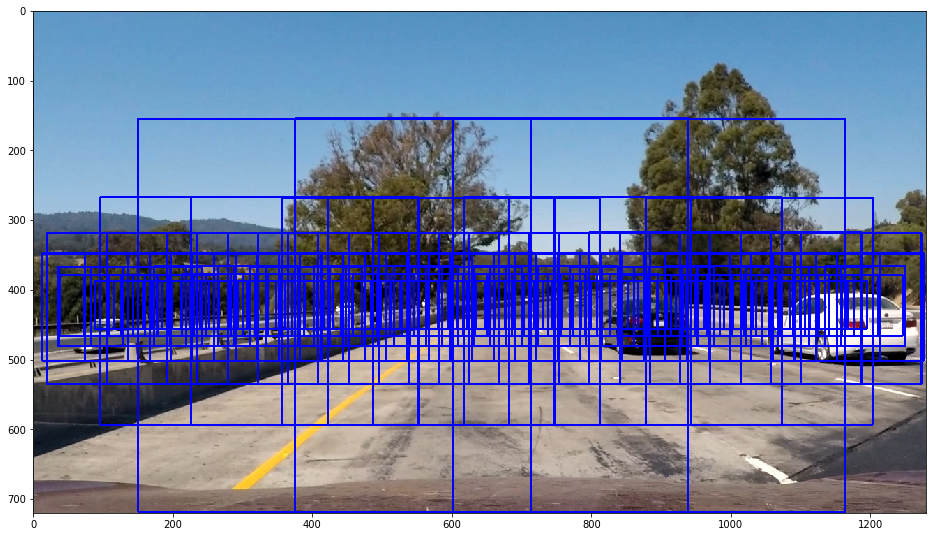

5


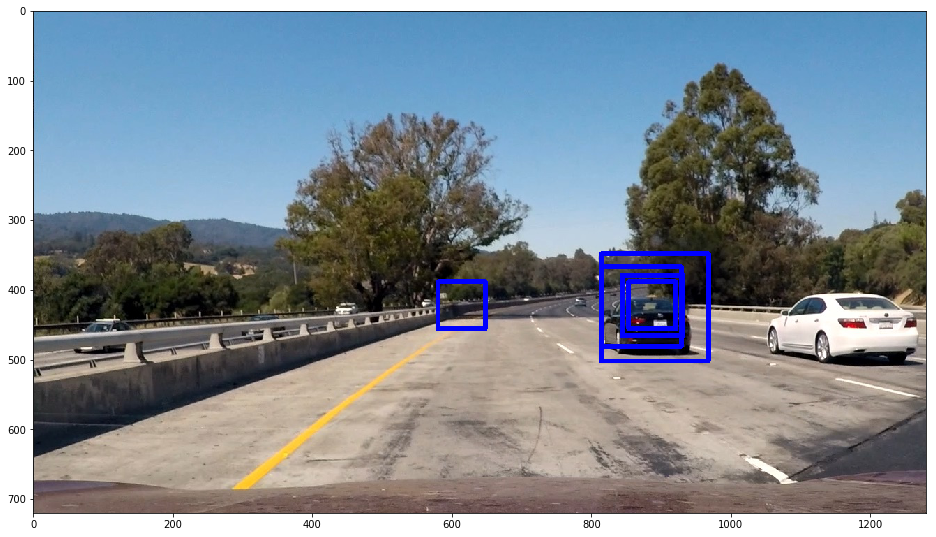

In [18]:
image = read_normalized('./test_images/test1.jpg')
draw_image = np.copy(image)

# Windows
windows = generate_windows(4)
#windows = slide_window(image, x_start_stop=[None,None], y_start_stop=[400, 720], 
#                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

draw_image = draw_boxes(draw_image, windows, thick=2)
plt.figure(figsize = (16,10))
plt.imshow(draw_image)
plt.show()

# Load classifier
clf = joblib.load('./cache/classifier.joblib.pkl')

# Load scaler
X_scaler = joblib.load('./cache/scaler.joblib.pkl')

hot_windows = search_windows(image, windows, clf, X_scaler, parameters)
print(len(hot_windows))

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.figure(figsize = (16,10))
plt.imshow(window_img)
plt.show()

## Hog Sub-sampling Window Search

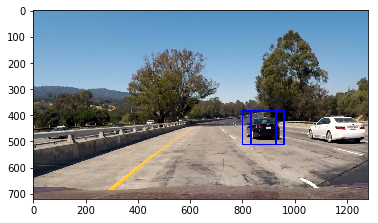

In [19]:

def find_cars(img, ystart, ystop, scale, svc, X_scaler, parameters):
    img_tosearch = img[ystart:ystop,:,:]
    
    hog_tosearch = convert_color_space(img_tosearch, parameters.hog_color_space)
    spatial_tosearch = np.copy(img_tosearch)
    
    #print("pix_per_cell", parameters.pix_per_cell)
    #print("cell_per_block", parameters.cell_per_block)
    
    if scale != 1:
        imshape = img_tosearch.shape
        width = imshape[1]
        height = imshape[0]
        hog_tosearch = cv2.resize(hog_tosearch, (np.int(width/scale), np.int(height/scale)))
        spatial_tosearch = cv2.resize(spatial_tosearch, (np.int(width/scale), np.int(height/scale)))
        
    ch1 = hog_tosearch[:,:,0]
    #ch2 = hog_tosearch[:,:,1]
    #ch3 = hog_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // parameters.pix_per_cell) - parameters.cell_per_block + 1
    nyblocks = (ch1.shape[0] // parameters.pix_per_cell) - parameters.cell_per_block + 1 
    nfeat_per_block = parameters.orient * parameters.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // parameters.pix_per_cell) - parameters.cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    #print("nyblocks",nyblocks)
    #print("nblocks_per_window",nblocks_per_window)
    #print("cells_per_step",cells_per_step)
    #print("nysteps",nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, parameters, feature_vec=False)
    #hog2 = get_hog_features(ch2, parameters, feature_vec=False)
    #hog3 = get_hog_features(ch3, parameters, feature_vec=False)
    
    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*parameters.pix_per_cell
            ytop = ypos*parameters.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(spatial_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            file_features = []
          
            # Get color features
            if parameters.spatial_feat == True:
                spatial_features = bin_spatial(subimg, parameters)
                file_features.append(spatial_features)
                
            if parameters.hist_feat == True:
                hist_features = color_hist(subimg, parameters)
                file_features.append(hist_features)
            
            if parameters.hog_feat == True:
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
                hog_features = hog_feat1
                file_features.append(hog_features)
    

            all_features = np.concatenate(file_features).reshape(1, -1)
            #np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            
            #print("Feature vector size:", len(all_features))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(all_features.reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                hot_windows.append([(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return hot_windows


img = read_normalized('./test_images/test1.jpg')
clf = joblib.load('./cache/classifier.joblib.pkl')
X_scaler = joblib.load('./cache/scaler.joblib.pkl')

ystart = 320
ystop = 700
scale = 2
    
hot_windows = find_cars(img, ystart, ystop, scale, clf, X_scaler, parameters)

draw_image = draw_boxes(img, hot_windows)
plt.imshow(draw_image)
plt.show()



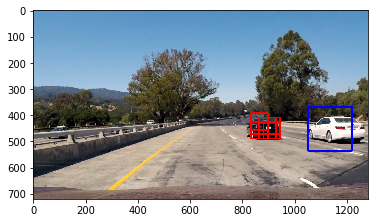

In [20]:
def calculate_scales():
    steps = 6
    smax = 5
    
    result = []
    
    sstep = np.power(smax, 1.0 / (steps-1))
    
    for i in range(steps):
        if i == 0:
            scale = 1
        else:
            scale = np.power(sstep, i)
        top = np.int(408 - scale * 15)
        bottom = np.int(460 + scale *  50)
        result.append((scale, top, bottom))
    
    return result


clf = joblib.load('./cache/classifier.joblib.pkl')
X_scaler = joblib.load('./cache/scaler.joblib.pkl')


def find_cars_ext(fname, scaler, clf, parameters):
    img = read_normalized(fname)
    
    colors = [(255,0,0),(0,255,0),(255,255,0), (0,0,255),(255,0,255),(0,255,255),(255,255,255)]
    scales = calculate_scales()
        
    for i in range(len(scales)):
        scale, ytop,ybottom = scales[i]
        hot_windows = find_cars(img, ytop, ybottom, scale, clf, X_scaler, parameters)
        #print(hot_windows)
        for window in hot_windows:
            cv2.rectangle(img, window[0], window[1], colors[i], 6)
    
    plt.imshow(img)
    plt.show()
    
    
find_cars_ext('./test_images/test1.jpg',X_scaler,clf,parameters)

## Heat map

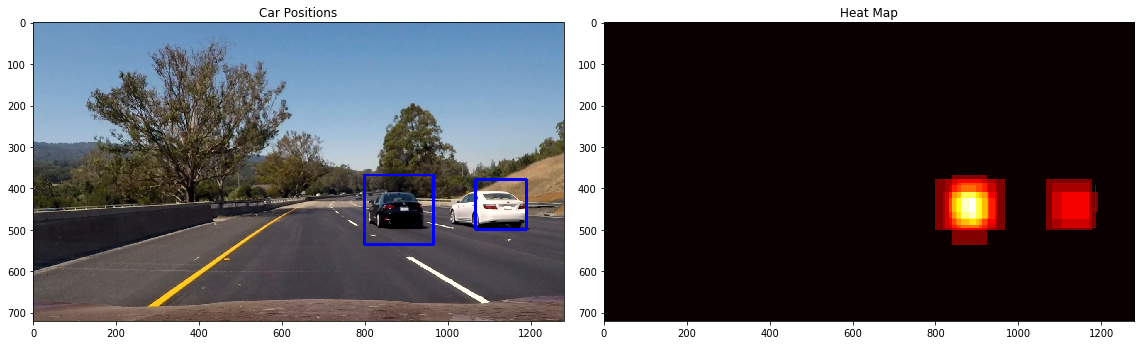

In [23]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    if labels[1] == 0:
        return img
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def frame_heatmap(image, scaler, clf, parameters):
    scales = calculate_scales()
   
    heat = np.zeros_like(image[:,:,0]).astype(np.float)  
    
    for scale, ytop,ybottom in scales:
        hot_windows = find_cars(image, ytop, ybottom, scale, clf, X_scaler, parameters)
        heat = add_heat(heat, hot_windows)
        
    return heat

def show_heatmap(fname, scaler, clf, parameters):
    image = read_normalized(fname)

    heat = frame_heatmap(image, X_scaler,clf,parameters)
    
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying 
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    plt.rcParams["figure.figsize"] = [16, 8]
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()
 
show_heatmap('./test_video/frame000.jpg',X_scaler,clf,parameters)

#show_heatmap('./test_images/test1.jpg',X_scaler,clf,parameters)
#show_heatmap('./test_images/test2.jpg',X_scaler,clf,parameters)
#show_heatmap('./test_images/test3.jpg',X_scaler,clf,parameters)
#show_heatmap('./test_images/test4.jpg',X_scaler,clf,parameters)
#show_heatmap('./test_images/test5.jpg',X_scaler,clf,parameters)
#show_heatmap('./test_images/test6.jpg',X_scaler,clf,parameters)


## Video pipeline

In [50]:
heat_threshold = 1
heat_maps = []
idx = 0

clf = joblib.load('./cache/classifier.joblib.pkl')
X_scaler = joblib.load('./cache/scaler.joblib.pkl')

def process_video_frame(image):
    sliding_window = 5
    global idx
    global heat_threshold
    global heat_maps
    
    #cv2.imwrite("./test_video/frame{num:03d}.jpg".format(num = idx), cv2.cvtColor(image,cv2.COLOR_RGB2BGR) )
    
    heat = frame_heatmap(image, X_scaler,clf,parameters)
    heat_maps.append(heat)
    
    count = min(len(heat_maps), sliding_window)
    if  count == 1:
        heat_sum = np.copy(heat)
    else:
        maps_to_sum = heat_maps[-count:]
        heat_sum = np.sum(maps_to_sum, axis=0) / count
    
    heat_sum = apply_threshold(heat_sum, heat_threshold)
    
    heatmap = np.clip(heat_sum, 0, 255)
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    idx += 1
    
    return draw_img

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

sampe_video = 'test_video.mp4'
video_output = 'test_video_output.mp4'

clip1 = VideoFileClip(sampe_video)
white_clip = clip1.fl_image(process_video_frame) 
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [02:02<00:26,  3.82s/it]